In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm  import tqdm
from sklearn.model_selection import GridSearchCV

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [2]:
# Открываем файл и смотрим содержимое
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# уменьшим размер используемой памяти, для скорости обучения
df = df.astype({'calls':'uint32', 
                    'minutes':'float32', 
                    'messages':'uint32', 
                    'mb_used':'float32', 
                    'is_ultra':'uint8'
                   })

In [4]:
# смотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   uint32 
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   uint32 
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   uint8  
dtypes: float32(2), uint32(2), uint8(1)
memory usage: 53.5 KB


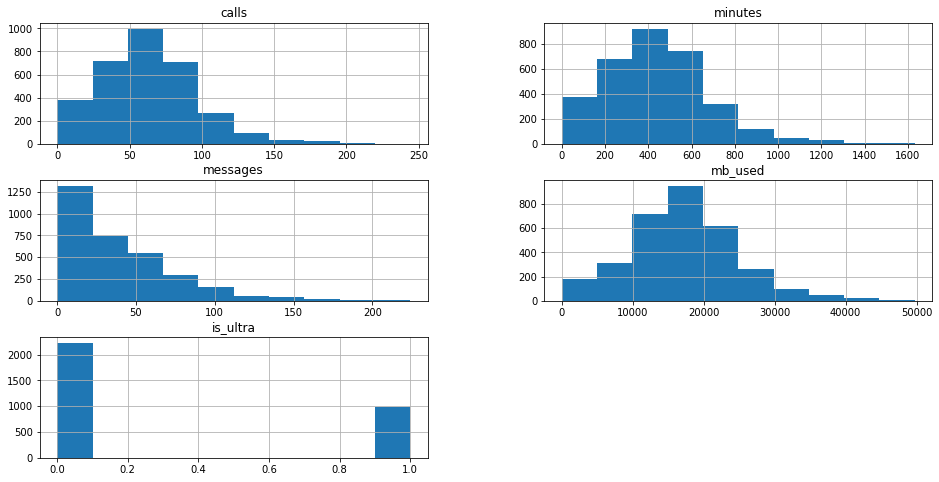

In [5]:
# Построим графики
df.hist(figsize=(16,8));

**Данные чистые и ухоженные, можно приступать у обучению**

## Разбейте данные на выборки

In [6]:
# Выделим признаки и целевой аргумент
X = df.loc[:,'calls':'mb_used']
y = df['is_ultra']

In [7]:
# Для разбиения на три выборки сначала выделим обучающую выборку, в размере 60%, а потом по 20% на валидационную и тестовую
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

In [8]:
print(f"Размер выборки train: X:{X_train.shape}, y:{y_train.shape}")
print(f"Размер выборки validation: X:{X_val.shape}, y:{y_val.shape}")
print(f"Размер выборки test: X:{X_test.shape}, y:{y_test.shape}")

Размер выборки train: X:(1928, 4), y:(1928,)
Размер выборки validation: X:(643, 4), y:(643,)
Размер выборки test: X:(643, 4), y:(643,)


## Исследуйте модели

**Для начала рассмотрим модели на обучающей выборке и выберем лучшую**

In [9]:
# Ближайшие соседи
model_kn = KNeighborsClassifier()
model_kn.fit(X_train, y_train)
pred = model_kn.predict(X_val)
model_score = accuracy_score(y_val, pred)
model_score

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7651632970451011

In [10]:
# Случайный лес
model_rf = RandomForestClassifier(random_state=12345)
model_rf.fit(X_train, y_train)
pred = model_rf.predict(X_val)
model_score = accuracy_score(y_val, pred)
model_score

0.7853810264385692

In [11]:
# Градиентный бустинг
model_gb = GradientBoostingClassifier(random_state=12345)
model_gb.fit(X_train, y_train)
pred = model_gb.predict(X_val)
model_score = accuracy_score(y_val, pred)
model_score

0.7900466562986003

**Как видим, градиентный бустинг на стоковых параметрах показал наилучший результат, поработаем с ним (в дополнение рассмотрим случайный лес)**

**Попробуем улучшить модели (повезло, что разрешили использовать автопоиск)**

In [12]:
# Возьмем набор гиперпараметров, которые будем перебирать
parametrs = {'n_estimators': range(1,51),
              'max_depth': range(1,6),
              'max_features': range(1,5)}

In [13]:
# Поиск лучших параметров для градиентного бустинга
model_gb = GradientBoostingClassifier(random_state=12345)
grid_gb = GridSearchCV(model_gb, parametrs, cv=5)
grid_gb.fit(X_train, y_train)
grid_gb.best_params_

{'max_depth': 5, 'max_features': 1, 'n_estimators': 36}

In [14]:
# Поиск лучших параметров для случайного леса
model_rf = RandomForestClassifier(random_state=12345)
grid_rf = GridSearchCV(model_rf, parametrs, cv=5)
grid_rf.fit(X_train, y_train)
grid_rf.best_params_

{'max_depth': 5, 'max_features': 2, 'n_estimators': 8}

In [15]:
# Обучим модель Градиентного бустинга на обучающей выборке и посмотрим на accuracy на валидациооной 
model_gb = GradientBoostingClassifier(max_depth=5, 
                                      max_features=1, 
                                      n_estimators=36, 
                                      random_state=12345)
model_gb.fit(X_train, y_train)
pred_gb = model_gb.predict(X_val)
model_score = accuracy_score(y_val, pred_gb)
model_score

0.7947122861586314

In [16]:
# Обучим модель Случайного леса на обучающей выборке и посмотрим на accuracy на валидациооной 
model_rf = RandomForestClassifier(max_depth=5, 
                                  max_features=2, 
                                  n_estimators=8, 
                                  random_state=12345)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
model_score = accuracy_score(y_val, pred_rf)
model_score

0.7931570762052877

**Случайный лес немного уступил Градиентному бустингу**

## Проверьте модель на тестовой выборке

In [17]:
# Посмотрим на тестовой выборке
model = GradientBoostingClassifier(max_depth=5, 
                                   max_features=1, 
                                   n_estimators=36, 
                                   random_state=12345)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model_score = accuracy_score(y_test, pred)
model_score

0.8040435458786936

**Как видим мы добились успеха получив accuracy свыше 0.75**

**При этом максимальная глубина у нас 5, число деревьев 36, а размер случайных подмножеств 1**

## (бонус) Проверьте модели на адекватность

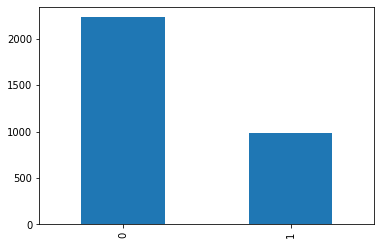

In [18]:
# Посмотрим на распределение классов
df['is_ultra'].value_counts().plot(kind='bar');

In [19]:
y_pred_constant = pd.Series([0 for _ in range(len(y))])
accuracy_score(y, y_pred_constant)

0.693528313627878

**Из-за несбалансированности классов, при подсчете accuracy, константная модель показывает, почти требуемый минимум точности, соотвественно при рассмотрении нашей модели, говорить об адекватности не стоит**

**Выводы
<br>1) Предоставленные данные были чистыми, с хорошей плотностью распеределения. Единственное, что было сделано с данными, уменьшена разрядность
<br>2) Разбиение на выборки были осуществлены в два этапа: 1. Сначала была выделена обучающая выборка в размере 60% 2. Были разбиты пополам оставшиеся 40% для валидационной и тестовой выборки
<br>3) Для обучения моделей были рассмотрены три варинта: 1. Ближайшие соседи 2. Случайный лес 3. Градиентный бустинг. Последний показал наилучший результат в стоковом режиме и с ним началась игра с гиперпараметрами
<br>4) Найдя наилушие гиперпараметры в частности глубина=5, количество_деревьев=36, а размер_подмножеств=1, проверив на обучающей выборке мы получили точность accuracy = 0.80. Что удовлетворяет нашей цели
<br>5) Но расмотрев распределение классов и сравнив с точностью константной модели, можно сделать вывод, что наша полученная модель не будет адекватной**